Sergi Flores i Sam Brumwell
# Pràctica 2: Detecció d'opinions 
En aquesta pràctica, treballarem amb el Movie Reviews Corpus de la biblioteca NLTK per desenvolupar models capaços de detectar el sentiment (positiu o negatiu) present en crítiques cinematogràfiques. El projecte s'estructura en dues parts diferenciades segons el mètode d'aprenentatge utilitzat:

#### Objectiu Principal
Crear sistemes que puguin determinar automàticament si una crítica de pel·lícula expressa una opinió positiva o negativa sobre aquesta, contribuint així a l'anàlisi de sentiment en textos.

### Part 1: Enfocament Supervisat (Pràctica 2.a)
En aquesta primera part, desenvoluparem un detector d'opinions basat en tècniques d'aprenentatge automàtic supervisat. Aquest enfocament requereix un conjunt d'entrenament etiquetat per poder funcionar correctament.

El procés inclourà:

Preprocessament de text
- Vectorització mitjançant CountVectorizer
- Modelatge com a problema de classificació binària
- Optimització d'hiperparàmetres mitjançant Cross-Validation
- Avaluació del model utilitzant mètriques de precisió i matrius de confusió

### Part 2: Enfocament No Supervisat (Pràctica 2.b)
La segona part es centra en un mètode no supervisat, que no requereix dades etiquetades per al seu funcionament. Utilitzarem:

- Els valors de SentiWordnet per a cada synset
- Selecció de categories gramaticals rellevants per a l'anàlisi
- Al final, compararem els resultats obtinguts amb ambdós enfocaments per avaluar l'eficàcia de cada mètode en la tasca de detecció de sentiment en crítiques cinematogràfiques.

In [2]:
import nltk
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords');
nltk.download('averaged_perceptron_tagger_eng');
nltk.download('wordnet');
nltk.download('sentiwordnet');
nltk.download('movie_reviews');

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


# Preprocessament

Abans d'entrenar els models, cal preparar les dades textuals per millorar el rendiment dels models. El preprocessament que apliquem inclou:

- **Conversió a minúscules**: Per estandarditzar tot el text
- **Eliminació de salts de línia**: Per millorar la continuïtat del text
- **Eliminació de signes de puntuació**: Per reduir el soroll en les dades
- **Tokenització**: Dividim el text en paraules individuals
- **Eliminació de stopwords**: Paraules comunes sense valor semàntic significatiu (com "the", "i'm", "what", etc.)
- **Lematització**: Reducció de les paraules a la seva forma base o arrel

Aquest preprocessament ens ajuda a reduir la dimensionalitat de les dades, eliminar soroll i centrar-nos en les paraules que realment aporten informació sobre el sentiment expressat en les crítiques cinematogràfiques. Cal destacar que hem decidit mantenir els nombres al preprocessament ja que poden aportar informació important a l'hora de modelar el sentiment, com hem pogut observar analíticament mitjançant les mètriques.

In [4]:
from nltk.corpus import movie_reviews as mr;
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower() # lowercase
    #text = re.sub(r'\d+', '', text) # remove numbers
    text = re.sub(r'\n', ' ', text) # remove new lines
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize the text and remove stop words
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(filtered_tokens) # return the text as string

### Divisió en train i test

Després del preprocessat, només cal separar les dades en un conjunt d'entrenament i un de test. El conjunt d'entrenament només s'utilitzarà per els models supervisats, ja que el model no-supervisat no li cal cap entrenament, així que les validacions dels models es faràn només amb el conjunt de test.

Per tal d'etiquetar correctament les dades per a l'entrenament dels models, s'han generat dues llistes fonamentals:
- **Text**: Que conté el text de cada resenya ja preprocessat.
- **Label**: Que indica si la crítica és positiva o negativa (variable objectiu)

Després dividim el conjunt en test i train amb un *test_size* de 0.2

In [5]:
fileids = mr.fileids()
categories = [mr.categories(fileid)[0] for fileid in fileids]  # 'pos' or 'neg'

data = pd.DataFrame({
    'text': [preprocess(mr.raw(fileid)) for fileid in fileids],   #Preprocess the text before creating the df
    'label': categories
})

# Split into train and test with stratify to balance categories
X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)

display(data.head())
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

,text,label
0,plot two teen couple go church party drink dri...,neg
1,happy bastard quick movie review damn y2k bug ...,neg
2,movie like make jaded movie viewer thankful in...,neg
3,quest camelot warner bros first featurelength ...,neg
4,synopsis mentally unstable man undergoing psyc...,neg


Train size: 1600
Test size: 400


### Vectorització del Text
Una vegada preprocessades les dades, cal transformar el text en un format numèric que pugui ser interpretat pels algoritmes d'aprenentatge automàtic. Així doncs utilitzarem el CountVectorizer, que converteix una col·lecció de documents de text en una matriu de freqüències de tokens.

In [6]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train).astype(np.float32)
X_test_vectorized = vectorizer.transform(X_test).astype(np.float32)

## Secció 1: Aprenentatge supervisat

Per a la classificació de les crítiques cinematogràfiques, hem implementat diversos models d'aprenentatge supervisat. Aquests models utilitzen algoritmes que aprenen patrons a partir del conjunt d'entrenament per diferenciar entre opinions positives i negatives.

### Models Implementats
Hem seleccionat i avaluat els següents classificadors de la biblioteca scikit-learn, on hem considerat el classificador que ens ha semblat més addient de cada família de models per al problema presentat:

- **Random Forest**: Un ensemble de múltiples arbres de decisió que funciona especialment bé amb dades d'alta dimensionalitat com les representacions vectorials de text.
- **K-Nearest Neighbors (KNN)**: Classifica cada nova mostra basant-se en les etiquetes de les k mostres més properes en l'espai de característiques.
- **Support Vector Machine (SVM)**: Busca l'hiperplà òptim que millor separa les classes, molt efectiu en espais d'alta dimensionalitat.
- **Logistic Regression**: Un model lineal que estima la probabilitat de pertànyer a una categoria. Tot i la seva simplicitat, sol funcionar bé en tasques de classificació de text en classes binàries.
- **LightGBM**: Un algoritme d'aprenentatge basat en gradient boosting, conegut per la seva eficàcia en diversos problemes de classificació.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Definir modelos con random_state donde sea aplicable
random_state = 42
logr = LogisticRegression(random_state=random_state)  # Aumentar max_iter para convergencia
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=random_state)
lgbm = LGBMClassifier(random_state=random_state, verbose=-1)
svm = SVC(random_state=random_state)

# Definir los grids de hiperparámetros para cada modelo
logr_params = {
    'max_iter': [1000],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

lgbm_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'num_leaves': [7, 15, 31], 
}

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

### Optimització d'Hiperparàmetres

Per maximitzar el rendiment de cada model, hem implementat un procés d'optimització exhaustiu utilitzant una metodologia sistemàtica:

#### Exploració de paràmetres
- Utilitzem un param grid específic per a cada classificador, definint combinacions d'hiperparàmetres rellevants per al seu funcionament òptim

#### Validació creuada (Cross-Validation)
- Implementem GridSearchCV amb 5-fold cross-validation per explorar sistemàticament l'espai d'hiperparàmetres
- La validació creuada divideix les dades d'entrenament en 5 parts, entrenant el model 5 vegades amb diferents combinacions de dades de training i validation
- Aquest enfocament proporciona una estimació més robusta del rendiment real del model i ajuda a evitar l'overfitting

#### Selecció del model
- Comparem els resultats obtinguts per identificar la configuració òptima per a cada classificador
- Aquest procés permet trobar el millor equilibri entre complexitat del model i capacitat de generalització

L'objectiu final d'aquesta fase és determinar quin classificador ofereix la millor precisió en la identificació del sentiment de les crítiques cinematogràfiques, assegurant que els models siguin tant precisos com generalitzables.

In [8]:
models = [
    ('Logistic Regression', logr, logr_params),
    ('KNN', knn, knn_params),
    ('Random Forest', rf, rf_params),
    ('LightGBM', lgbm, lgbm_params),
    ('SVM', svm, svm_params)
]

best_params = {}
best_scores = {}

for name, model, params in models:
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        verbose=2)

    grid_search.fit(X_train_vectorized, y_train)

    best_params[name] = grid_search.best_params_
    best_scores[name] = grid_search.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [9]:
results_df = pd.DataFrame({
    'Model': list(best_scores.keys()),
    'Best Score': list(best_scores.values()),
    'Best Parameters': list(best_params.values())})

results_df = results_df.sort_values('Best Score', ascending=False)

display(results_df)

,Model,Best Score,Best Parameters
0,Logistic Regression,0.836875,"{'C': 0.1, 'max_iter': 1000, 'solver': 'liblin..."
2,Random Forest,0.830625,"{'max_depth': 10, 'max_features': 'sqrt', 'min..."
4,SVM,0.823750,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}"
3,LightGBM,0.819375,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."
1,KNN,0.570625,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei..."


### Anàlisi Comparativa dels Models
Tots els models excepte el KNN han donat resultats de precisió relativament similars en l'optimització d'hiperparàmetres. La Regressió Logística ha obtingut la millor puntuació (0.837), seguida pel Random Forest (0.831), SVM (0.824) i LightGBM (0.819).

El model de KNN ha donat un resultat molt pitjor en comparació amb els altres (0.571), possiblement degut a les limitacions dels mètodes que utilitza per calcular distàncies entre veïns en espais d'alta dimensionalitat com els que es generen en la vectorització de text. En aquestes representacions, la majoria de les característiques tenen o valor 1 o 0 (presència o absència d'una paraula), fet que dificulta la presència de veïns significatius.

Aquest fet il·lustra que els models basats en distàncies com KNN no són tan efectius per a tasques de classificació de text com els models que poden capturar relacions més complexes o que s'adapten millor a dades d'alta dimensionalitat i disperses, així doncs l'ometrm en les properes validacions respecte el conjunt de test

## Avaluació dels Models amb el Conjunt de Test
Una vegada entrenats tots els models amb el conjunt d'entrenament i optimitzats els seus hiperparàmetres mitjançant validació creuada, el següent pas és avaluar el seu rendiment utilitzant el conjunt de test. Aquest conjunt conté dades que els models no han vist durant l'entrenament, cosa que ens permet mesurar la seva capacitat real de generalització.

### Procés d'Avaluació
Per cada model optimitzat, el procés d'avaluació consisteix en:

- **Predicció sobre dades noves**: Aplicar el model optimitzat al conjunt de test per obtenir les prediccions

- **Càlcul de mètriques**: Per a cada model, calcular l'accuracy i visualitzar la matriu de confusió 

- **Visualització dels resultats**: Representació gràfica de les mètriques per facilitar la comparació entre models



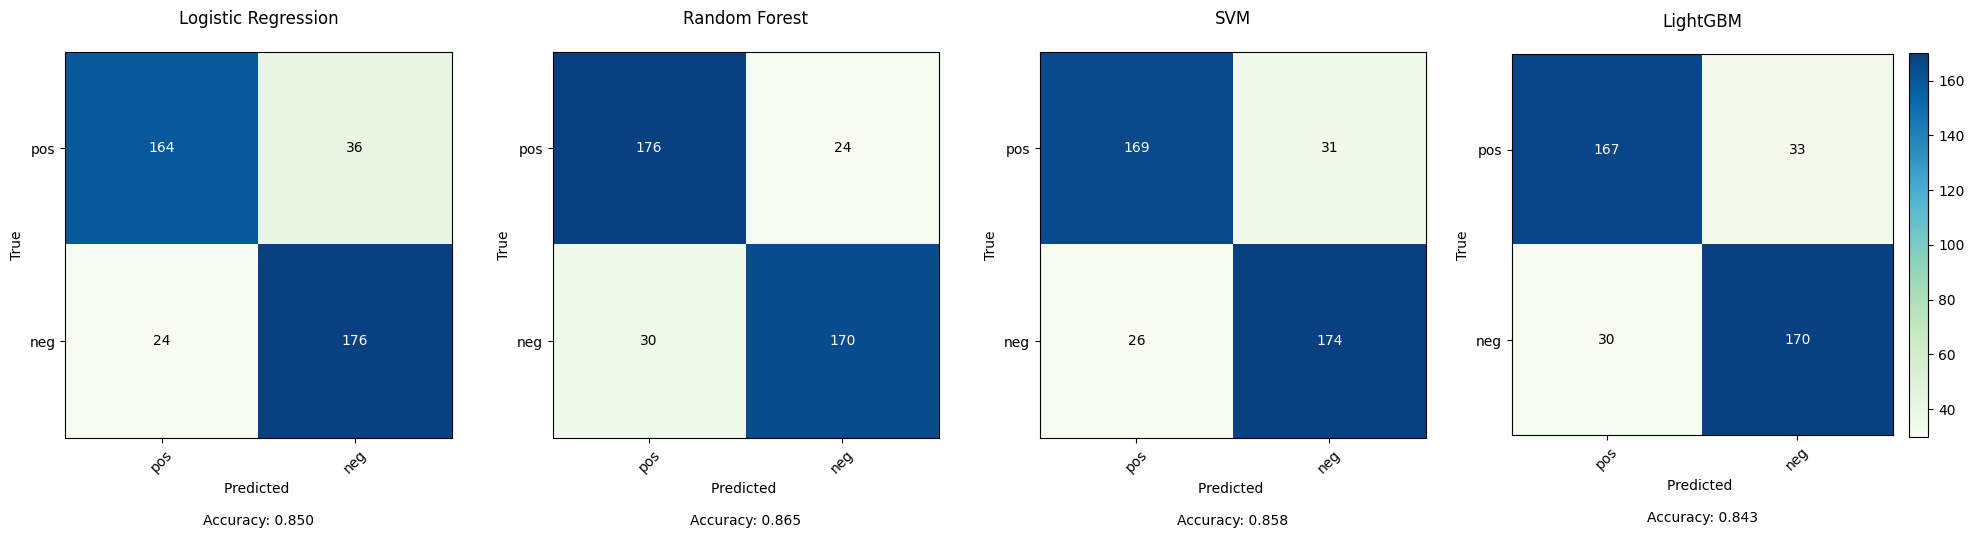

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

results_filtered = results_df[results_df['Best Score'] > 0.7]
n_models = len(results_filtered) 
plt.figure(figsize=(5 * n_models, 5))  # 

for idx, (index, row) in enumerate(results_filtered.iterrows(), 1):
    model_name = row['Model']
    model_params = best_params[model_name]

    # Train models with best hyperparameters
    model = next(model for name, model, params in models if name == model_name)
    model.set_params(**model_params)

    # Train and predict
    model.fit(X_train_vectorized, y_train)
    y_pred = model.predict(X_test_vectorized)
    
    # Calculate metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Plot confusion matrix
    ax = plt.subplot(1, n_models, idx)
    im = ax.imshow(conf_matrix, cmap='GnBu') 
    ax.set_title(f"{model_name}", pad=20)
    ax.set_xticks(np.arange(len(set(y_test))), labels=set(y_test), rotation=45)
    ax.set_yticks(np.arange(len(set(y_test))), labels=set(y_test))
    ax.set_xlabel(f'Predicted \n\nAccuracy: {accuracy:.3f}')
    ax.set_ylabel('True')
    
    # Cell text
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, conf_matrix[i, j],
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
            
# Add colorbar only for the fourth plot
if idx == 4:
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Resultats Comparatius

L'anàlisi dels diferents models revela diferències significatives en el seu rendiment. El Random Forest destaca com el model amb millor rendiment general, obtenint els millors resultats en les validacions sobre el conjunt de test amb un accuracy de (0.865). 

Els models lineals com SVM i Logistic Regression també mostren un bon equilibri entre precisió i capacitat de generalització, amb resultats molt propers al Random Forest. De la mateixa manera el LightGBM mostra uns resultats similars, tot i que podem deduir que la naturalesa de les dades textuals i la classificació binària de sentiment s'adapten particularment bé a l'enfocament d'ensemble d'arbres de decisió que caracteritza al Random Forest.

### Curva ROC

A continuació hem generat la curva ROC del model seleccionat, que mostra un AUC de 0.93, que indica un molt bon rendiment del model. La corba mostra com el model manté un bon equilibri entre sensibilitat (taxa de verdaders positius) i especificitat (1 - taxa de falsos positius), el que és especialment important en un context on ambdues classes tenen la mateixa importància com és el cas.



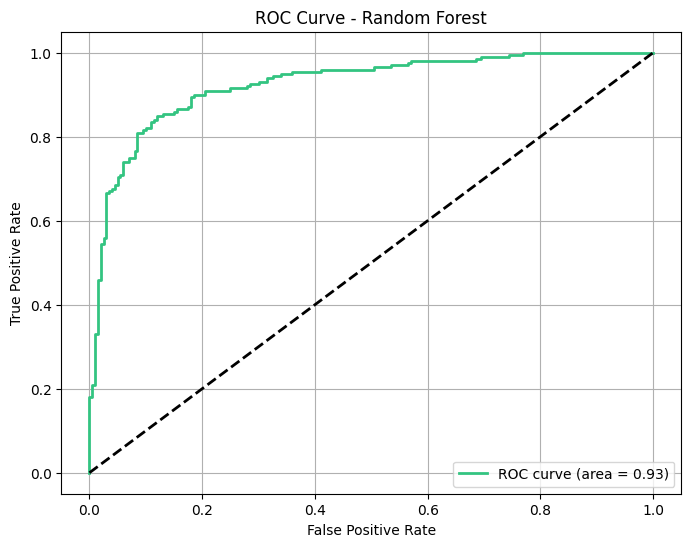

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtain probabilities for the positive class
rf = RandomForestClassifier(random_state=random_state)
rf.set_params(**best_params['Random Forest'])
rf.fit(X_train_vectorized, y_train)
y_pred_roc = rf.predict_proba(X_test_vectorized)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_roc, pos_label='pos')
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#33C481', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Secció 2:  Model d'aprenentatge no supervisat

En aquesta secció generarem un model d'aprenentatge no supervisat, és a dir, un model que no requereix d'un conjunt de dades d'entrenament etiquetat. A diferència dels models supervisats que aprenen patrons a partir d'exemples etiquetats, aquest enfocament utilitza recursos lèxics per determinar el sentiment.

### Utilització de SentiWordNet

Per aquesta pràctica utilitzarem SentiWordNet, un recurs lèxic derivat de WordNet que assigna tres puntuacions a cada synset (conjunt de sinònims):

- **Puntuació positiva**: Indica la intensitat de les connotacions positives (entre 0 i 1)
- **Puntuació negativa**: Indica la intensitat de les connotacions negatives (entre 0 i 1)
- **Puntuació neutra**: Calculada com 1 - (positiva + negativa)

### Funcionament del Model

El model opera seguint aquests principis:

1. **Anàlisi paraula per paraula**: Processa cada paraula del text de la crítica
2. **Assignació de puntuacions**: Utilitza SentiWordNet per obtenir les puntuacions positives i negatives
3. **Suma de puntuacions**: Acumula les puntuacions per a totes les paraules rellevants del text
4. **Decisió final**: Declara que la crítica és positiva si la puntuació positiva acumulada és més alta que la negativa, i viceversa

Cal destacar que la majoria de les paraules tenen una puntuació neutra molt més elevada que els dos altres sentiments. Com que assumim que no hi han crítiques neutres que aportin informació al model, hem decidit descartar aquesta puntuació neutra del nostre càlcul.

### Importància de l'Anàlisi Gramatical

Per a que aquest model funcioni correctament, cal primer determinar la categoria gramatical de cada paraula del text. Aquesta classificació és crucial pels següents motius:

- **Desambiguació lèxica**: Moltes paraules tenen diferents significats segons el seu ús gramatical
- **Selecció del synset adequat**: SentiWordNet pot identificar la definició correcta només si coneix la categoria gramatical
- **Precisió en l'anàlisi**: Permet distingir entre usos diferents de la mateixa paraula (per exemple, "cool" com a adjectiu positiu vs. "cool" com a verb neutre)

Quan una paraula té múltiples definicions dins la mateixa categoria gramatical, el model utilitza l'algoritme de Lesk per seleccionar el sentit més apropiat segons el context.

### Mètodes de Suma de Puntuacions

Hem implementat diversos mètodes per sumar les puntuacions de sentiment, cadascun amb característiques diferents, de manera que posteriorment puguem comparar-ne els resultats. Aquests són els mètodes implementats:

- **Standard**: Suma totes les puntuacions positives i negatives directament
- **Max**: Només suma la puntuació més alta (positiva o negativa) per cada paraula  
- **Binary**: Compta simplement quantes paraules són més positives que negatives i viceversa
- **Squared**: Eleva al quadrat les puntuacions per donar més pes a sentiments intensos
- **Harmonic**: Utilitza la mitjana harmònica entre puntuacions positives i negatives

In [12]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn
import math

def get_wordnet_category(pos):
    wdnet_pos = None
    if pos.startswith('J'):
        wdnet_pos = wn.ADJ
    elif pos.startswith('N'):
        wdnet_pos = wn.NOUN
    elif pos.startswith('R'):
        wdnet_pos = wn.ADV
    elif pos.startswith('V'):
        wdnet_pos = wn.VERB
    return wdnet_pos

def sentiment_classifier(text, categories={'a', 'n', 'r', 'v', 's'}, metode_suma='standard'):
    pos_score, neg_score = 0, 0

    word_tokenize_list = word_tokenize(text)
    tagged_words = nltk.pos_tag(word_tokenize_list)

    for word, pos in tagged_words:
        wdnet_pos = get_wordnet_category(pos)

        if categories is None or wdnet_pos in categories:
            synset = lesk(word_tokenize_list, word, wdnet_pos)

            if synset is None and wdnet_pos == wn.ADJ and 's' in categories:
                synset = lesk(word_tokenize_list, word, wn.ADJ_SAT)
            
            if synset is not None:
                swn_synset = swn.senti_synset(synset.name())
                pos = swn_synset.pos_score()
                neg = swn_synset.neg_score()

                if metode_suma == 'standard':
                    pos_score += pos
                    neg_score += neg

                elif metode_suma == 'max':
                    if pos > neg:
                        pos_score += pos
                    else:
                        neg_score += neg
                
                elif metode_suma == 'binary':
                    if pos > neg:
                        pos_score += 1
                    else:
                        neg_score += 1

                elif metode_suma == 'squared':
                    pos_score += pos*pos if pos > neg else 0
                    neg_score += neg*neg if neg >= pos else 0

                elif metode_suma == 'harmonic':
                    # Evitar divisió per zero
                    if pos + neg > 0:
                        if pos > neg:
                            pos_score += 2 * pos * neg / (pos + neg) if pos + neg > 0 else 0
                        else:
                            neg_score += 2 * pos * neg / (pos + neg) if pos + neg > 0 else 0
                
    
    return 'pos' if pos_score >= neg_score else 'neg'

## Optimització de Paràmetres del Model No Supervisat

Un cop generat el model basat en SentiWordNet, necessitem optimitzar-ne els paràmetres per maximitzar la seva precisió. A diferència dels models supervisats on optimitzem hiperparàmetres algorítmics, en aquest cas l'optimització se centra principalment en determinar quines categories gramaticals són més informatives per a l'anàlisi de sentiment.

### Selecció de Categories Gramaticals Òptimes
Les categories gramaticals disponibles per a l'anàlisi inclouen:

- **Adjectius (a)**: Descriuen qualitats i solen tenir forta càrrega emocional ("excellent", "terrible")
- **Noms (n)**: Denominen entitats i conceptes, generalment més neutres en sentiment
- **Adverbis (r)**: Modifiquen verbs i adjectius, poden intensificar sentiment ("extremely", "hardly")
- **Verbs (v)**: Indiquen accions, alguns amb càrrega emocional ("love", "hate")
- **Adjectius satèl·lit (s)**: Adjectius complementaris que poden reforçar el sentiment principal

### Procés d'Avaluació
Per determinar la millor combinació:

1. **Avaluació sistemàtica**: Provem diferents combinacions de categories gramaticals
2. **Mesura del rendiment**: Calculem la precisió comparant les prediccions amb les etiquetes reals
3. **Anàlisi d'errors**: Identifiquem categories que poden introduir confusió en el model

Per no elevar sense motiu la càrrega computacional, s'han seleccionat les combinacions que contenen més càrrega emocional, com ara adjectius i adverbis. A més, el s'utilizarà un subconjunt de validació extret del test per tal d'accelerar l'execució.

### Mètodes d'Agregació de Sentiment
A més de les categories gramaticals, experimentem amb diferents mètodes per agregar les puntuacions de sentiment mencionats anteriorment, on les diferents combinacions d'aquests paràmetres ens permetran identificar la configuració òptima per maximitzar la precisió del nostre classificador de sentiment no supervisat.

In [13]:
from itertools import combinations

top_combinations = []
# Generate all possible combinations of categories
categories_set = {'a', 'n', 'r', 'v', 's'}  # a=adj, n=noun, r=adv, v=verb, s=adj satellite
suma_methods = ['standard', 'max', 'binary', 'squared', 'harmonic']

# Let's also try some specific meaningful combinations
meaningful_combinations = [
    {'a', 's'},                 # adjectives only
    {'a', 'r'},                 # adjectives and adverbs
    {'a', 'r', 's'},            # adjectives, adverbs and adj satellites          
    {'a', 'v', 'r', 's'},       # all except nouns
    {'n', 's', 'r', 'a'},       # all except verbs
    {'n', 'v', 'r', 'a', 's'}  # all categories
]

for method in suma_methods:
    for comb in meaningful_combinations:
        X_test_sentiment_sample = X_test.apply(lambda x: sentiment_classifier(x, categories=comb, metode_suma=method))
        accuracy = accuracy_score(y_test, X_test_sentiment_sample)
        top_combinations.append((comb, method, accuracy))

top_combinations = sorted(top_combinations, key=lambda x: x[2], reverse=True)
print(f"\nBest Combination: {top_combinations[0][0]}, Best Method: {top_combinations[0][1]}, Best Accuracy: {top_combinations[0][2]:.4f}")


Best Combination: {'s', 'a'}, Best Method: standard, Best Accuracy: 0.6525




Com podem veure, al conjunt de validació la millor combinació d'hiperparàmetres ha sigut d'adjectius, adjectius satelitals i adverbis amb el mètode de suma estàndard. Tot i això, a continuació mostrarem les matrius de confussió de les 4 millors combinacions de paràmetres per tenir més perspectiva a l'hora d'analitzar els resultats.

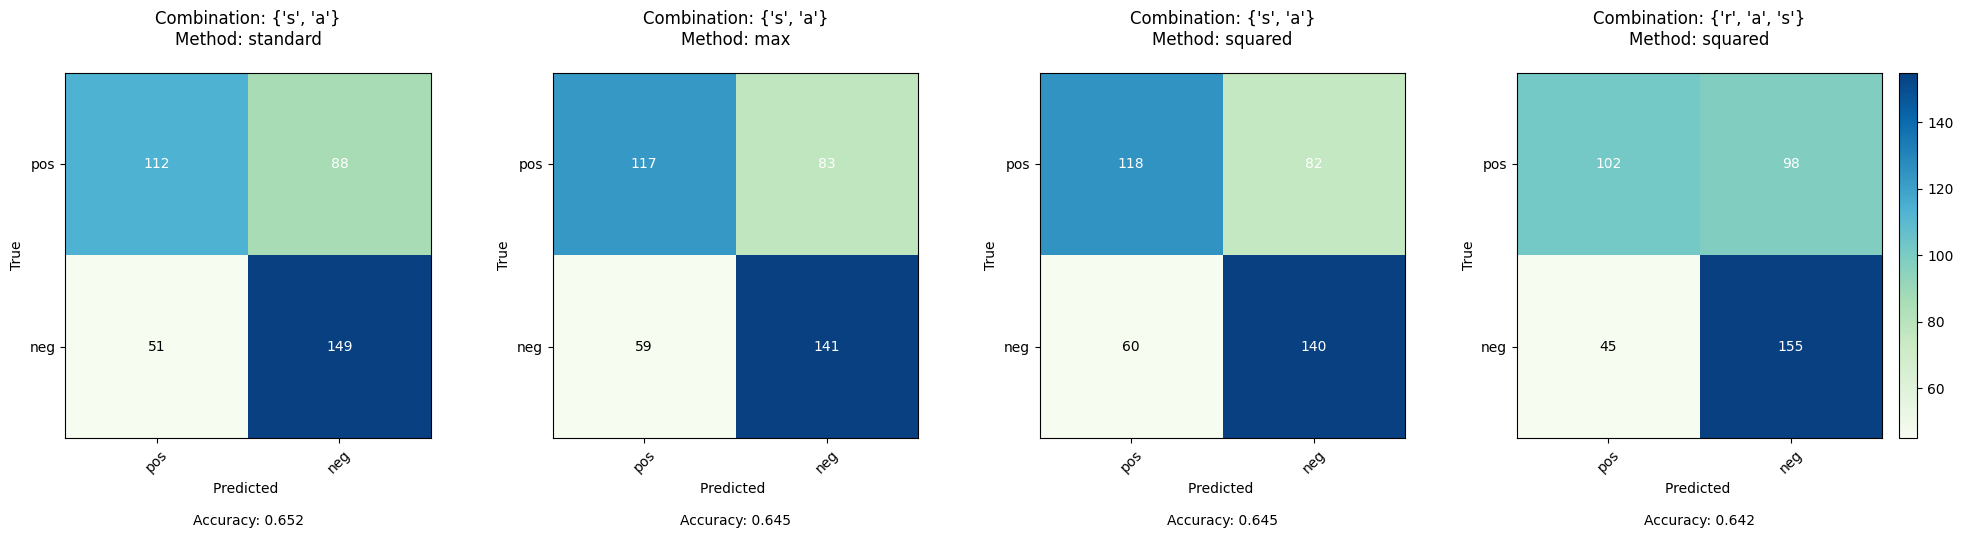

In [14]:
n_models = 4
plt.figure(figsize=(5 * n_models, 5))

for idx, (comb, metode, _) in enumerate(top_combinations[:n_models], 1):
    # Calculate predictions
    y_pred = X_test.apply(lambda x: sentiment_classifier(x, categories=set(comb), metode_suma=metode))

    # Calculate metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Plot confusion matrix
    ax = plt.subplot(1, n_models, idx)
    im = ax.imshow(conf_matrix, cmap='GnBu')
    ax.set_title(f"Combination: {comb}\nMethod: {metode}", pad=20)
    ax.set_xticks(np.arange(len(set(y_test))), labels=set(y_test), rotation=45)
    ax.set_yticks(np.arange(len(set(y_test))), labels=set(y_test))
    ax.set_xlabel(f'Predicted \n\nAccuracy: {accuracy:.3f}')
    ax.set_ylabel('True')

    # Add cell text
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, conf_matrix[i, j],
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    
    # Add colorbar only for the fourth plot
    if idx == 4:
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Amb els resultats anteriors es pot veure que la millor combinació és el mètode de suma estàndard amb el conjunt de tots els adjectius. Tot i això també es pot observar com altres mètodes de suma com *max* o *squared* també han mostrat bons resultats. Tot i això, com a altres combinacions de categories rellevants la següent opció és afegir-hi els adverbis, que tot i semblar aportar informació rellevant per a la predicció de sentiments positius, sembla aportar redundància en el cas de classificacions negatives.

## Comparativa del model supervisat i no supervisat

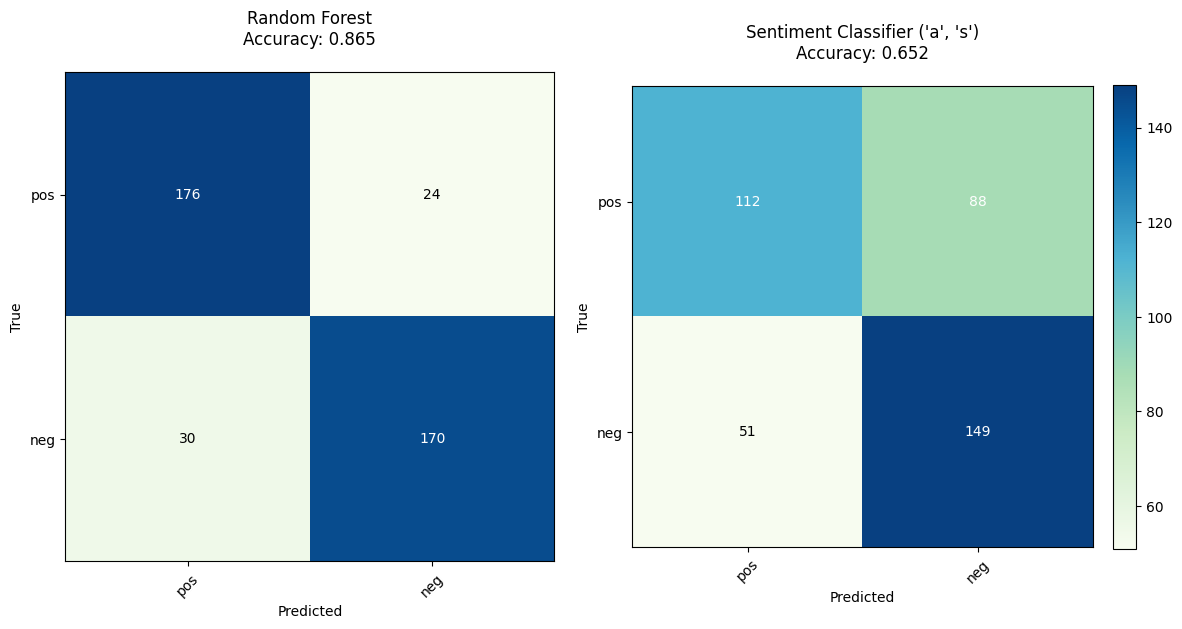

In [15]:
# Train Random Forest and predict
rf = RandomForestClassifier(random_state=random_state, **best_params['Random Forest'])
rf.fit(X_train_vectorized, y_train)
y_pred_rf = rf.predict(X_test_vectorized)
# Predict with sentiment classifier
y_pred_sentiment = X_test.apply(lambda x: sentiment_classifier(x, categories={'a', 's'}))

# Confusion matrices
conf_matrices = [
    (confusion_matrix(y_test, y_pred_rf), "Random Forest", accuracy_score(y_test, y_pred_rf)),
    (confusion_matrix(y_test, y_pred_sentiment),
     "Sentiment Classifier ('a', 's')", accuracy_score(y_test, y_pred_sentiment))
]

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, (conf_matrix, title, accuracy) in zip(axes, conf_matrices):
    im = ax.imshow(conf_matrix, cmap='GnBu')
    ax.set_title(f"{title}\nAccuracy: {accuracy:.3f}", pad=20)
    ax.set_xticks(np.arange(len(set(y_test))), labels=set(y_test), rotation=45)
    ax.set_yticks(np.arange(len(set(y_test))), labels=set(y_test))
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, conf_matrix[i, j], ha="center", va="center",
                    color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
            
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Model Supervisat vs. No Supervisat

El model supervisat (Random Forest) ha demostrat ser significativament superior al model no supervisat basat en SentiWordNet, amb una precisió del 86.5% enfront del 65.2%. Aquesta diferència es deu principalment a:

- **Aprenentatge contextual**: Els models supervisats poden captar relacions complexes entre paraules i frases, mentre que els enfocaments basats en lèxic tendeixen a analitzar les paraules de manera més aïllada.

- **Especificitat del domini**: El model supervisat aprèn característiques específiques del domini de les crítiques cinematogràfiques, mentre que SentiWordNet utilitza puntuacions de sentiment generals.

- **Maneig de fenòmens lingüístics**: Els models supervisats poden capturar millor la negació, la ironia o el sarcasme, elements freqüents en les crítiques i difícils d'identificar amb aproximacions lèxiques.

### Importància de les Categories Gramaticals

En el model no supervisat, hem observat que els adjectius i satèl·lits adjectivals són les categories gramaticals que més contribueixen a la detecció correcta del sentiment. Això confirma la intuïció lingüística que els adjectius tenen un paper fonamental en l'expressió d'opinions i valoracions.

### Impacte de la Mida del Conjunt d'Entrenament

El model supervisat requereix un conjunt d'entrenament suficient per generalitzar correctament. Tot i això, fins i tot amb conjunts d'entrenament relativament petits, el model supervisat continua superant el model no supervisat, demostrant l'efectivitat de l'aprenentatge automàtic per a aquesta tasca. A continuació generem un gràfic de l'accuracy del Random Forest segons la mida del conjunt d'entrenament actual per veure l'impacte real d'aquest.

### Aplicacions Pràctiques

Segons els resultats obtinguts, per a aplicacions que requereixin alta precisió en l'anàlisi de sentiment de crítiques cinematogràfiques, el model supervisat seria la millor opció. No obstant això, el model no supervisat pot ser útil en escenaris on no es disposi de dades etiquetades o es vulgui implementar una solució ràpida sense necessitat d'entrenament.

En definitiva, aquesta pràctica demostra la superioritat dels models d'aprenentatge supervisat en tasques d'anàlisi de sentiment, tot i que els enfocaments basats en recursos lèxics continuen sent una alternativa viable quan no es disposa de dades etiquetades.

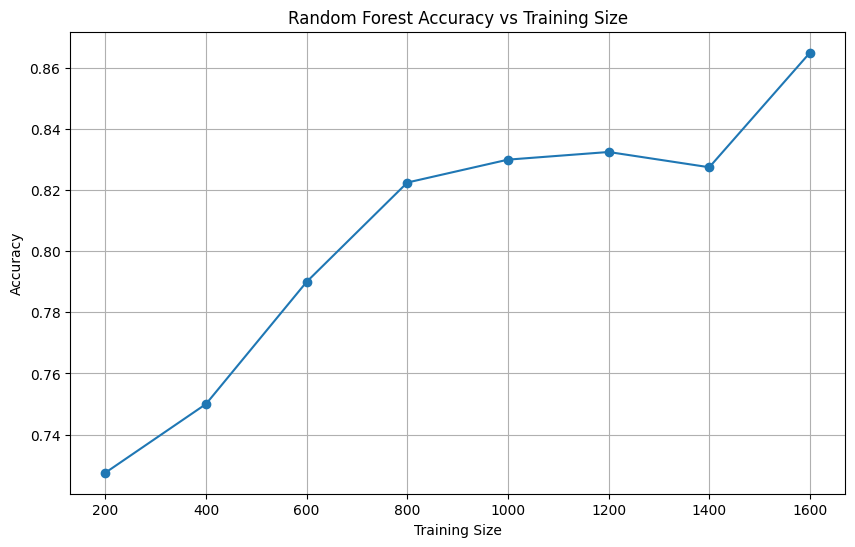

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Asumo que X_train_vectorized y y_train están definidos previamente
total_samples = X_train_vectorized.shape[0]
sample_sizes = list(range(200, 1600, 200)) + [total_samples]  # [200, 400, 600, 800, 1000, 1200, 1400, 1600, total]

results = []

# Verificar que el último tamaño sea efectivamente el total del dataset
if sample_sizes[-1] != total_samples:
    sample_sizes[-1] = total_samples

# Iterar sobre los tamaños de muestra definidos
for mida in sample_sizes:
    if mida == total_samples:  # Si es el último tamaño, usa todos los datos
        X_train_sample = X_train_vectorized
        y_train_sample = y_train
    else:
        # Obtener muestra aleatoria SIN REPETICIÓN (replace=False)
        sample_indices_train = np.random.RandomState(random_state).choice(
            total_samples, size=mida, replace=False)
        X_train_sample = X_train_vectorized[sample_indices_train]
        y_train_sample = y_train.iloc[sample_indices_train]
    
    # Entrenar el modelo y predecir
    rf = RandomForestClassifier(random_state=random_state, **best_params['Random Forest'])
    rf.fit(X_train_sample, y_train_sample)
    y_pred_rf = rf.predict(X_test_vectorized)
    
    # Calcular y almacenar la precisión
    rf_accuracy = accuracy_score(y_test, y_pred_rf)
    results.append({
        'Training Size': mida,
        'Random Forest Accuracy': rf_accuracy,
    })

accuracy_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(accuracy_df['Training Size'], accuracy_df['Random Forest Accuracy'], marker='o')
plt.title('Random Forest Accuracy vs Training Size')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### Precisió del model segons el train size
Com podem veure amb aquests resultats, com menor és el conjunt d'entrenament menys precisió obtenim sobre els resultats. Tot i això, fins i tot amb conjunts de dades de 200 files obtenim millors resulats que amb el mètode d'aprenentatge no supervisat, de manera que podem confirmar que per a aquest problema l'ús de classificadors supervisats ens dona un millor rendiment.

In [22]:
# Find false positives and false negatives for Random Forest
fp_rf = X_test[(y_test == 'neg') & (y_pred_rf == 'pos')]
fn_rf = X_test[(y_test == 'pos') & (y_pred_rf == 'neg')]

# Find false positives and false negatives for Sentiment Classifier
fp_sentiment = X_test[(y_test == 'neg') & (y_pred_sentiment == 'pos')]
fn_sentiment = X_test[(y_test == 'pos') & (y_pred_sentiment == 'neg')]

print("Random Forest Model")
print("------------------")
print("First 2 False Positives (Predicted Positive but actually Negative):")
for i, text in enumerate(fp_rf.iloc[:2]):
    print(f"{i+1}. {text}...")
    
print("\nFirst 2 False Negatives (Predicted Negative but actually Positive):")
for i, text in enumerate(fn_rf.iloc[:2]):
    print(f"{i+1}. {text}...")

print("\n\nSentiment Classifier Model")
print("------------------")
print("First 2 False Positives (Predicted Positive but actually Negative):")
for i, text in enumerate(fp_sentiment.iloc[:2]):
    print(f"{i+1}. {text}...")
    
print("\nFirst 2 False Negatives (Predicted Negative but actually Positive):")
for i, text in enumerate(fn_sentiment.iloc[:2]):
    print(f"{i+1}. {text}...")

print()

Random Forest Model
------------------
First 2 False Positives (Predicted Positive but actually Negative):
1. thirteenth floor bland obligatory exercise genre filmmaking hadnt recently watched matrix open eye similar far superior might little nicer picture craig bierko make adequate hero douglas hall rich cocreator perfect human world simulation suddenly blamed murder bos armin muellerstahl everything subtle smart previously mentioned film battered head one character stare maddeninglylong period time refuse communicate realistic level acting okay film suffers every logical flaw one could think feature script copenned director josef rusnak loaded cliche stock character individual scene idea work like thought sentient computer program none film strength recognized meaningful degree producer roland emmerich based previous directorial effort seems hellbent bringing u ultimate standard mediocre sciencefiction...
2. mandingo traditionally seen one two thing either muchneeded revisionist look


## Anàlisi d'Errors i Conclusions del Model

### Patrons Identificats en les Classificacions Errònies

Analitzant els falsos positius i falsos negatius dels dos models, podem observar patrons interessants:

- **Llenguatge complex i amb matisos**: Ambdós models tenen dificultats amb crítiques que utilitzen llenguatge subtil o que discuteixen aspectes negatius d'una pel·lícula mentre són globalment positives (o viceversa).

- **Errors comuns**: Hi ha crítiques que són mal classificada pels dos models, suggerint que certes ressenyes són inherentment difícils de classificar independentment del plantejament utilitzat.

- **Comprensió del context**: Els models mostren limitacions per entendre el context complet. Per exemple, en el Random Forest, la resenya fals negativa és positiva però utilitza termes que descriuen elements de la trama potencialment negatius que confonen l'algoritme.

- **Sentiment mixt**: Les crítiques amb sentiment mixt tendeixen a ser mal classificades, com les ressenyes que discuteixen tant aspectes problemàtics com elements d'interès històric tot i que no directament positiu.

- **Sarcasme i ironia**: Hi ha crítiques que contenen termes com *"excellent premise"*, que confonen l'anàlisi basat en el lèxic, ja que són positives tot i ser ironies i que el text sigui globalment negatiu.

### Diferències entre els Models

- **Random Forest**: Sembla més robust amb crítiques complexes però encara mostra dificultats amb ressenyes que contenen termes contradictoris o que parlen de temes negatius de manera positiva.

- **Model no supervisat**: És especialment sensible a paraules individuals amb forta càrrega sentimental, sense considerar adequadament el context global de la ressenya.

### Conclusions

Aquests resultats suggereixen que, tot i que el model supervisat ofereix millor rendiment en general, un enfocament híbrid que combini aprenentatge automàtic amb anàlisi basat en lèxic podria ser l'estratègia òptima per gestionar la complexitat i els matisos del llenguatge en les crítiques cinematogràfiques.
